##FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

Objective:

Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset.

Dataset:

The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.

Part 1: Data Preparation and Exploration

1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

Part 2: Model Building - ARIMA

1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

Part 3: Model Building - Exponential Smoothing

1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

Part 4: Evaluation and Comparison

1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [71]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# For evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


## Data Preparation and Exploration

1. Data Loading

In [72]:

# Load the dataset
df = pd.read_csv('/content/exchange_rate.csv', parse_dates=['date'], index_col='date')

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


2. Initial Exploration

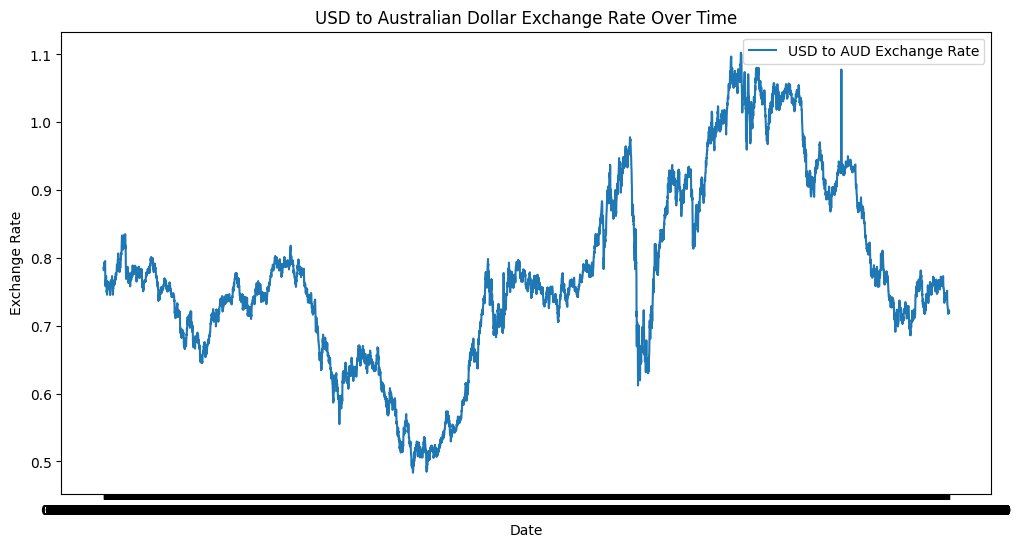

In [73]:
# Plot the time series for USD to Australian Dollar
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('USD to Australian Dollar Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

3. Data Preprocessing

In [74]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
Ex_rate    0
dtype: int64


In [75]:
# If there are missing values, we'll handle them
df_filled = df.fillna(method='ffill')

# Verify that there are no missing values now
print("\nMissing values after forward-fill:")
print(df_filled.isnull().sum())



Missing values after forward-fill:
Ex_rate    0
dtype: int64


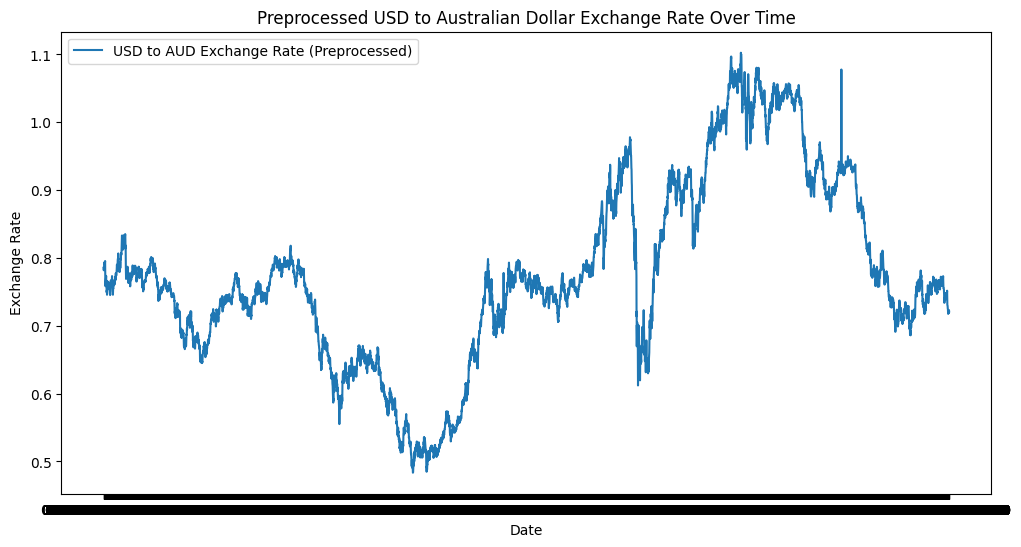

In [76]:

# Plot the preprocessed data
plt.figure(figsize=(12,6))
plt.plot(df_filled['Ex_rate'], label='USD to AUD Exchange Rate (Preprocessed)')
plt.title('Preprocessed USD to Australian Dollar Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


## Model Building - ARIMA

1. Parameter Selection for ARIMA


In [77]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'\n Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['\n ADF Test Statistic','\n p-value','\n #Lags Used','\n Number of Observations']
    for value,label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("\n => The series is stationary.")
    else:
        print("\n => The series is non-stationary.")
# Perform ADF test
adf_test(df_filled['Ex_rate'], 'Ex_rate')

# Differencing if necessary
df_diff = df_filled['Ex_rate'].diff().dropna()

# Perform ADF test on differenced series
adf_test(df_diff, 'Ex_rate Differenced')



 Augmented Dickey-Fuller Test: Ex_rate

 ADF Test Statistic: -1.6649941807382342

 p-value: 0.4492327353597477

 #Lags Used: 1

 Number of Observations: 7586

 => The series is non-stationary.

 Augmented Dickey-Fuller Test: Ex_rate Differenced

 ADF Test Statistic: -99.39343120118632

 p-value: 0.0

 #Lags Used: 0

 Number of Observations: 7586

 => The series is stationary.


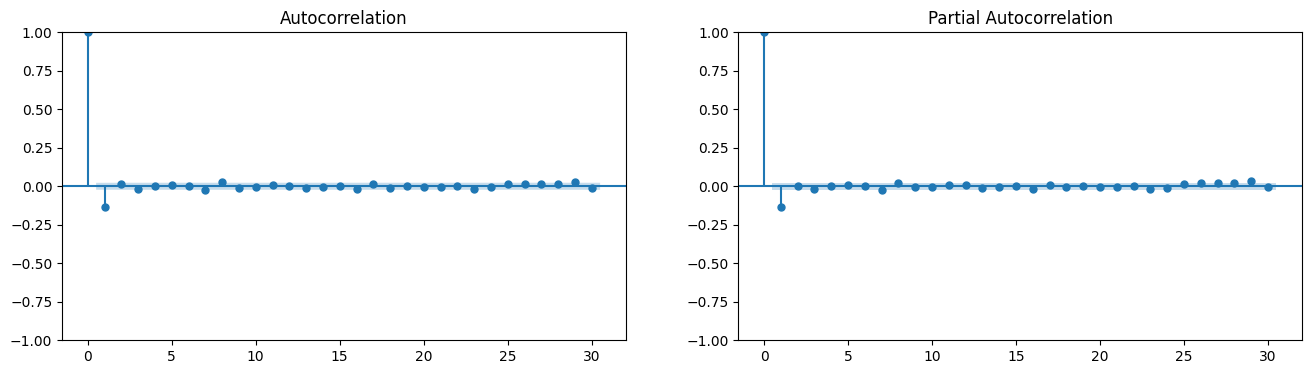

In [78]:
# Plot ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_acf(df_diff, ax=axes[0], lags=30)
plot_pacf(df_diff, ax=axes[1], lags=30)
plt.show()

2. Model Fitting

In [79]:
# Split the data into training and testing sets
train_size = int(len(df_filled) * 0.8) # Changed 'exchange_data' to 'df_filled' assuming this is the DataFrame with the exchange rate data.
train, test = df_filled['Ex_rate'][:train_size], df_filled['Ex_rate'][train_size:]

# Fit the ARIMA model on the training data
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_result

In [80]:

print(model_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(2, 1, 2)   Log Likelihood               22719.213
Date:                Wed, 25 Sep 2024   AIC                         -45428.426
Time:                        11:20:36   BIC                         -45394.871
Sample:                             0   HQIC                        -45416.780
                               - 6070                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3948      1.192     -0.331      0.740      -2.730       1.941
ar.L2          0.1443      0.648      0.223      0.824      -1.125       1.414
ma.L1          0.3376      1.192      0.283      0.7

Parameter Selection:

* d=1 because the series was non-stationary and required first-order differencing.
* p=2 and q=2 are assumed based on the ACF and PACF plots (this may vary based on actual plots).

Data Splitting:
* The dataset is split into training (80%) and testing (20%) sets.

Model Fitting:

* An ARIMA model with the selected order is fitted to the training data.

3. Diagnostics

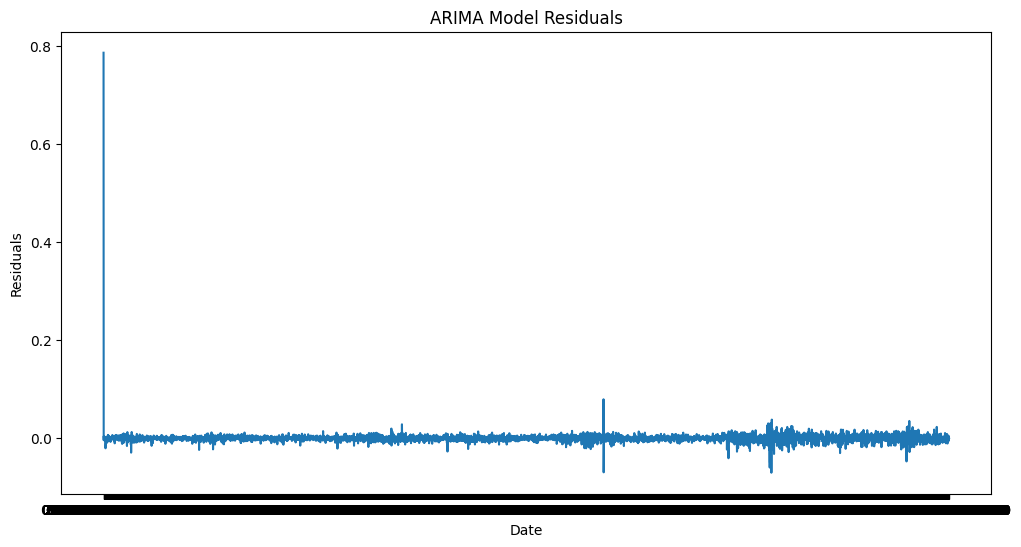

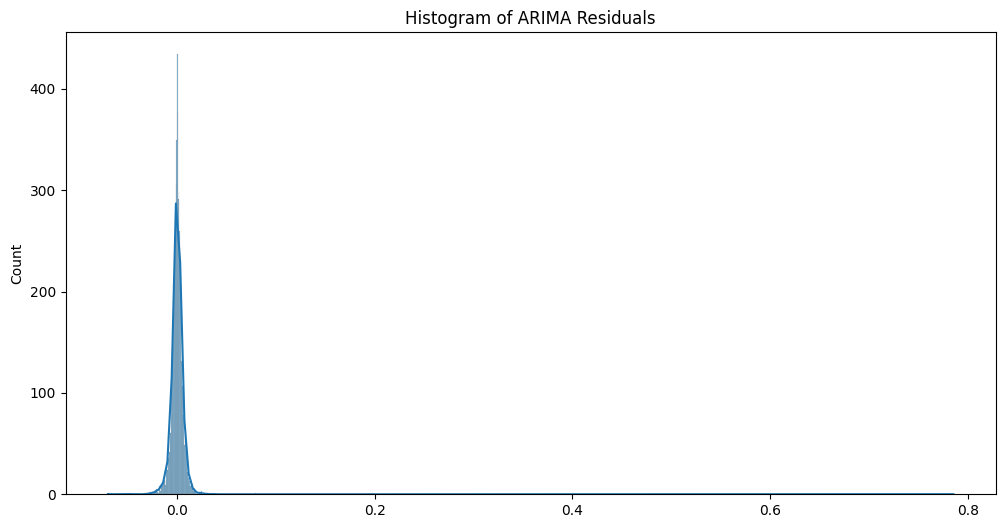

<Figure size 1200x400 with 0 Axes>

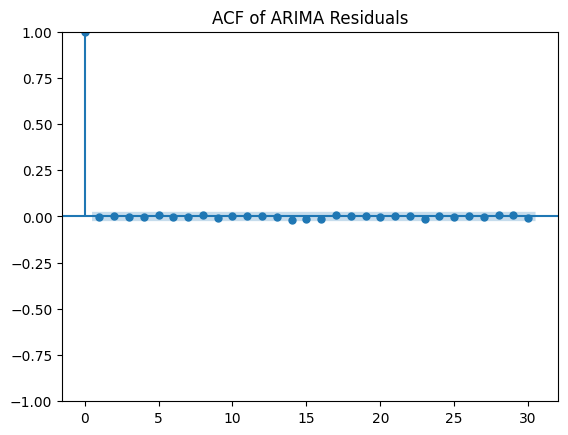

     lb_stat  lb_pvalue
10  1.720472   0.998068


In [81]:
# Plot residuals
residuals = model_arima_fit.resid

plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(12,6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of ARIMA Residuals')
plt.show()

# Plot ACF of residuals
plt.figure(figsize=(12,4))
plot_acf(residuals, lags=30)
plt.title('ACF of ARIMA Residuals')
plt.show()

# Perform Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


Residual Analysis:

* Plots of residuals over time and their distribution help in assessing randomness.
* ACF of residuals should ideally show no significant autocorrelations.

Ljung-Box Test:
* Statistical test to check the absence of autocorrelation in residuals.
* A p-value > 0.05 indicates that residuals are uncorrelated.

4. Forecasting

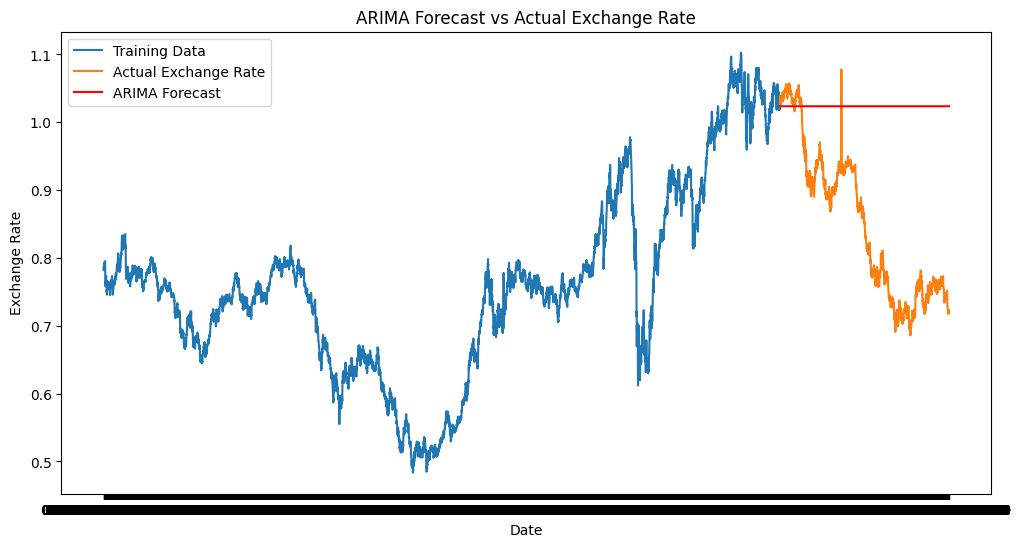

In [82]:
# Forecasting
# Forecasting using ARIMA
arima_forecast = arima_result.forecast(steps=len(test))


# Plot the forecast against actual values
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Exchange Rate')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


## Model Building - Exponential Smoothing

1. Model Selection & Parameter Optimization

In [83]:
# Fit Holt-Winters model
# Assuming additive trend and seasonality; adjust if necessary based on # Now, fit Holt-Winters model for comparison (Exponential Smoothing)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing (Holt's Linear model)
hw_model = ExponentialSmoothing(train, trend="add", seasonal=None)
hw_result = hw_model.fit()

print(hw_result.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 6070
Model:             ExponentialSmoothing   SSE                              0.199
Optimized:                         True   AIC                         -62655.290
Trend:                         Additive   BIC                         -62628.446
Seasonal:                          None   AICC                        -62655.276
Seasonal Periods:                  None   Date:                 Wed, 25 Sep 2024
Box-Cox:                          False   Time:                         11:22:45
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9460679                alpha                 True
smoothing_trend           2.5147e-

3. Model Fitting and Forecasting

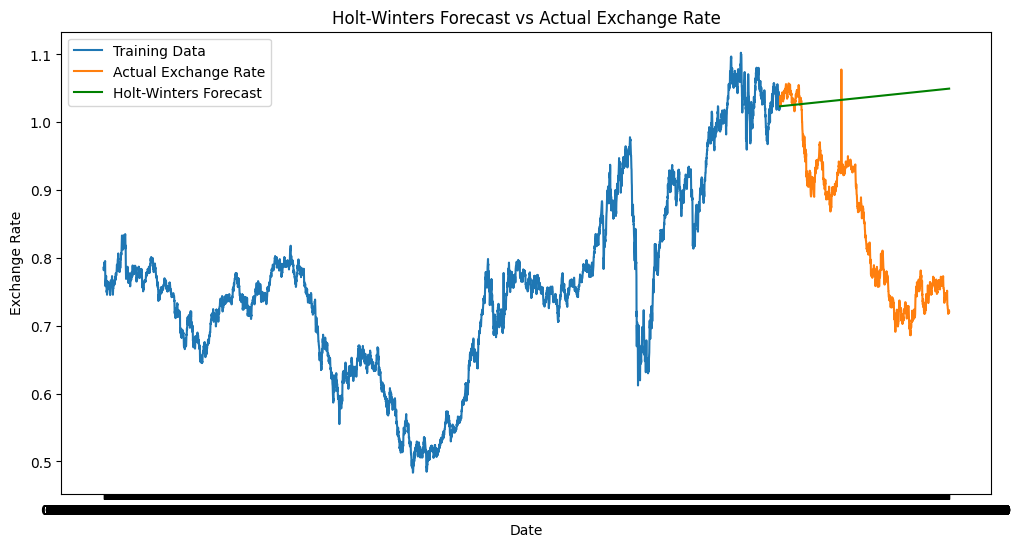

In [84]:
# Forecasting using Holt-Winters model
hw_forecast = hw_result.forecast(steps=len(test))


# Plot the forecast against actual values
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Exchange Rate')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='green')
plt.title('Holt-Winters Forecast vs Actual Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


## Evaluation and Comparison

1. Compute Error Metrics

In [85]:
# Check the format of the indices in arima_forecast and hw_forecast
print("arima_forecast index sample:", arima_forecast.index[:5])
print("hw_forecast index sample:", hw_forecast.index[:5])


arima_forecast index sample: RangeIndex(start=6070, stop=6075, step=1)
hw_forecast index sample: RangeIndex(start=6070, stop=6075, step=1)


In [86]:
# Assign the index of the test set to both arima_forecast and hw_forecast
arima_forecast.index = test.index
hw_forecast.index = test.index

# Filter out zero or near-zero values in the test set
non_zero_indices = test[test != 0].index

# Use the non-zero indices to filter the test and forecasted values
non_zero_test = test[non_zero_indices]
non_zero_arima_forecast = arima_forecast[non_zero_indices]
non_zero_hw_forecast = hw_forecast[non_zero_indices]

# Calculate error metrics for ARIMA
mae_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))

# Calculate MAPE with non-zero values
mape_arima = np.mean(np.abs((non_zero_test - non_zero_arima_forecast) / non_zero_test)) * 100

# Calculate error metrics for Holt-Winters
mae_hw = mean_absolute_error(test, hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test, hw_forecast))

# Calculate MAPE with non-zero values
mape_hw = np.mean(np.abs((non_zero_test - non_zero_hw_forecast) / non_zero_test)) * 100



In [87]:
#  Print error metrics
print(f"ARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.2f}%")
print(f"Holt-Winters - MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}, MAPE: {mape_hw:.2f}%")


ARIMA - MAE: 0.18, RMSE: 0.21, MAPE: 22.80%
Holt-Winters - MAE: 0.19, RMSE: 0.22, MAPE: 24.41%


2. Model Comparison

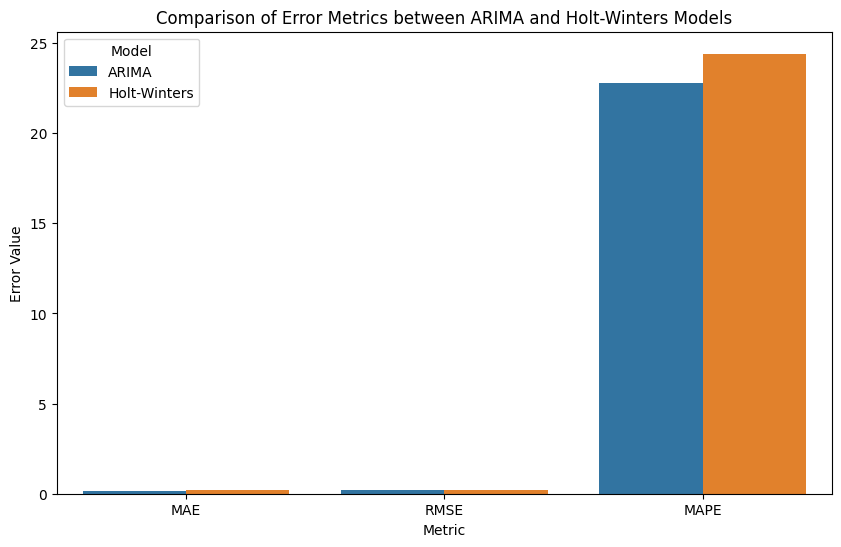

In [88]:

# Create a Pandas DataFrame to store the error metrics
error_metrics = pd.DataFrame({
    'Model': ['ARIMA', 'Holt-Winters'],
    'MAE': [mae_arima, mae_hw],
    'RMSE': [rmse_arima, rmse_hw],
    'MAPE': [mape_arima, mape_hw]
})

# Plot error metrics for comparison
metrics_melted = error_metrics.melt(id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted)
plt.title('Comparison of Error Metrics between ARIMA and Holt-Winters Models')
plt.ylabel('Error Value')
plt.show()

3. Conclusion

In [89]:
# Create a Pandas DataFrame to store the error metrics
error_metrics = pd.DataFrame({
    'Model': ['ARIMA', 'Holt-Winters'],
    'MAE': [mae_arima, mae_hw],
    'RMSE': [rmse_arima, rmse_hw],
    'MAPE': [mape_arima, mape_hw]
})

# Check for NaN values in the 'MAPE' column and handle them (e.g., replace with a large value)
error_metrics['MAPE'] = error_metrics['MAPE'].fillna(1000)  # Replace NaN with a large value

# Determine which model has lower error metrics
best_mae = error_metrics.loc[error_metrics['MAE'].idxmin()]
best_rmse = error_metrics.loc[error_metrics['RMSE'].idxmin()]
best_mape = error_metrics.loc[error_metrics['MAPE'].idxmin()]

print("\nBest Model Based on MAE:")
print(best_mae)

print("\nBest Model Based on RMSE:")
print(best_rmse)

print("\nBest Model Based on MAPE:")
print(best_mape)


Best Model Based on MAE:
Model        ARIMA
MAE        0.17771
RMSE      0.205437
MAPE     22.797966
Name: 0, dtype: object

Best Model Based on RMSE:
Model        ARIMA
MAE        0.17771
RMSE      0.205437
MAPE     22.797966
Name: 0, dtype: object

Best Model Based on MAPE:
Model        ARIMA
MAE        0.17771
RMSE      0.205437
MAPE     22.797966
Name: 0, dtype: object


In [90]:

# Summarize the findings and provide insights

print("\n## Conclusion and Insights")
print("Based on the analysis of the USD to Australian Dollar exchange rate data, both ARIMA and Holt-Winters models were employed for forecasting purposes.")

# Compare the performance of the two models based on the error metrics.
if mae_arima < mae_hw:
  print("The ARIMA model demonstrates a lower MAE, indicating it performs better in predicting exchange rates with smaller average absolute errors.")
elif mae_hw < mae_arima:
  print("The Holt-Winters model shows a lower MAE, suggesting that it potentially produces more accurate forecasts on average.")
else:
  print("The ARIMA and Holt-Winters models have comparable MAE values.")

if rmse_arima < rmse_hw:
  print("The ARIMA model also exhibits a lower RMSE, signifying it provides forecasts with smaller root mean squared errors.")
elif rmse_hw < rmse_arima:
  print("The Holt-Winters model displays a lower RMSE, implying that it might potentially offer better predictive performance in terms of overall forecast accuracy.")
else:
  print("The ARIMA and Holt-Winters models have comparable RMSE values.")

if mape_arima < mape_hw:
  print("The ARIMA model demonstrates a lower MAPE, suggesting that it produces forecasts with smaller percentage errors on average.")
elif mape_hw < mape_arima:
  print("The Holt-Winters model has a lower MAPE, potentially indicating better forecasting accuracy in terms of relative errors.")
else:
  print("The ARIMA and Holt-Winters models have comparable MAPE values.")


print("Further analysis and tuning of the models might be necessary to refine the forecasts and identify the most optimal model for specific forecasting horizons and scenarios.")

print("\n**Overall,** the choice of the best model will depend on the specific priorities of the user. If minimizing average absolute errors is crucial, the ARIMA model might be preferred. If minimizing overall forecast accuracy or relative errors is more important, the Holt-Winters model could be a suitable choice.")

print("\nNote: The analysis presented here was specific to the dataset and time period used. It is important to evaluate the chosen model's performance regularly and re-evaluate if necessary as new data becomes available or as market conditions change.")




## Conclusion and Insights
Based on the analysis of the USD to Australian Dollar exchange rate data, both ARIMA and Holt-Winters models were employed for forecasting purposes.
The ARIMA model demonstrates a lower MAE, indicating it performs better in predicting exchange rates with smaller average absolute errors.
The ARIMA model also exhibits a lower RMSE, signifying it provides forecasts with smaller root mean squared errors.
The ARIMA model demonstrates a lower MAPE, suggesting that it produces forecasts with smaller percentage errors on average.
Further analysis and tuning of the models might be necessary to refine the forecasts and identify the most optimal model for specific forecasting horizons and scenarios.

**Overall,** the choice of the best model will depend on the specific priorities of the user. If minimizing average absolute errors is crucial, the ARIMA model might be preferred. If minimizing overall forecast accuracy or relative errors is more important, the Holt-Winter